In [1]:
# Загрузка биьлиотек
import pandas as pd
import sqlite3 as db

import datetime as dt
import multiprocessing
from multiprocessing import Pool, Manager

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import pprint
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from package.select_run_test import SampleComparisonTest

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering, KMeans

# 3. Оценка эффективности первой рекламной кампании

## 3.1. Формирование данных AB-тестирования из  имеющихся источников

In [2]:
# Загрузим итоговый датаcет из хранилища
connection = db.connect('data/purchases.db')
print("База данных создана и подключена")
query = 'SELECT * FROM full_table'
df_all = pd.read_sql_query(query, connection)
print("Таблица заполнена")
connection.close()
print("Соединение с базой данных закрыто")

База данных создана и подключена
Таблица заполнена
Соединение с базой данных закрыто


## 3.2. Оценка первой рекламной кампании

In [3]:
# Функция чтения признаков проведения AB-тестов
# и загрузки признаков тестовой и контрольной выборок
def f_indexes(df, col, file_name, value):
    def f(x, y, value, indexes):
        if x in indexes:
            return value
        else:
            return y
    
    indexes = list()
    with open(file_name) as file:
        while True:
            line = file.readline()
            if not line:
                break
            row = line[:-1].replace(' ', ',').replace(';', ',').split(',')
            for elem in row:
                if elem.isdigit():
                    indexes.append(int(elem))
    
    # Оставим только уникальные значения индексов
    indexes = list(set(indexes))
    print(f'Количество записей {file_name[-12:-4]}: {len(indexes)}')

    df[col] = df.apply(lambda x: f(x.id, x[col], value, indexes), axis=1)

    return df

In [4]:
# Добавим в датасет признак тестовой группы
col = 'test'
df_all[col] = None

# Заполним признак данными о тестовой группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_positive.txt', 1)

# Заполним признак данными о контрольной группе потребителей
df_all = f_indexes(df_all, col, 'data/result_data/ids_first_company_negative.txt', 0)

Количество записей positive: 5016
Количество записей negative: 5009


**Вывод:** количество покупателей, совершивших покупки в тестовой и контрольной группах, сбалансировано. Соответсвенно тестовая и контрольные группы реливантны.

In [5]:
# Получим датасет выбранный для AB тестирования первой маркетенговой компании
df_AB_1 = df_all[~(df_all.test.isna()) & (df_all.dt<16)]
print(f'Количесвто записей для расчёта AB теста: {df_AB_1.shape[0]}')
# Датасеты тестовой и контрольной групп
df_test = df_AB_1[df_AB_1.test == 1]
df_control = df_AB_1[df_AB_1.test == 0]
print(f'Количество записей positive: {len(df_test)}')
print(f'Количество записей negative: {len(df_control)}')

Количесвто записей для расчёта AB теста: 47120
Количество записей positive: 29850
Количество записей negative: 17270


Эффективность проведённой рекламной кампании можно проверить по:
 - увеличению стоимости покупок покупателями,  
 - увеличению частоты покупок,
 - увеличение покупок группой клиентов в возрасной категории от 26 до 60 лет (как наиболее состоятельной)
 https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik

### 3.2.1. Проверка метрики "Увеличение стоимости покупок"

In [6]:
# Сформируем выборки по стоимости покупок покупателей
df_test_cost = df_test.groupby('dt').agg({'cost': 'sum'})
df_control_cost = df_control.groupby('dt').agg({'cost': 'sum'})

In [7]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_cost['cost'], df_control_cost['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 56.596833%
  - вторая выборка: 0.270581%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.001593%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.5659683346748352,
  'p-value df2': 0.002705811057239771},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 1.5932777797286954e-05}}

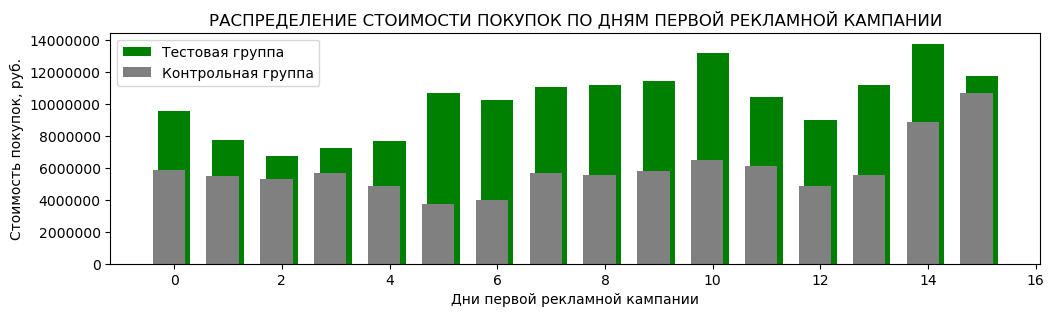

In [8]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ПОКУПОК ПО ДНЯМ ПЕРВОЙ РЕКЛАМНОЙ КАМПАНИИ')
ax.set_ylabel('Стоимость покупок, руб.')
ax.set_xlabel('Дни первой рекламной кампании')
ax.bar(df_test_cost.index, df_test_cost['cost'], width=0.6,
       color='green', label='Тестовая группа')
ax.bar(df_control_cost.index-0.1, df_control_cost['cost'], width=0.6,
       color='gray', label='Контрольная группа')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.legend();

**Вывод:** Первая рекуламная кампании значительно увеличила стоимость продаж практически в каждый день её проведения.

### 3.2.2. Проверка метрики "Изменение частоты покупок"

In [9]:
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})

In [10]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_client['product'], df_control_client['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 0.000000%
  - вторая выборка: 0.000000%
--------------------------------------
 ВЫВОД: Одна или все выборки НЕПАРАМЕТРИЧЕСКИЕ (не распеределены по нормальному закону распределения)


  Для сравнения выборок выбран тест: Критерий Мана-Уитни
 ЗНАЧЕНИЕ p-value при тестировании выборок: 0.000000%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо РАЗЛИЧАЮТСЯ (гипотеза H1)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.0,
  'p-value df2': 0.0},
 'Результат': {'name_test': 'Критерий Мана-Уитни',
  'p-value': 4.0493932665489114e-109}}

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


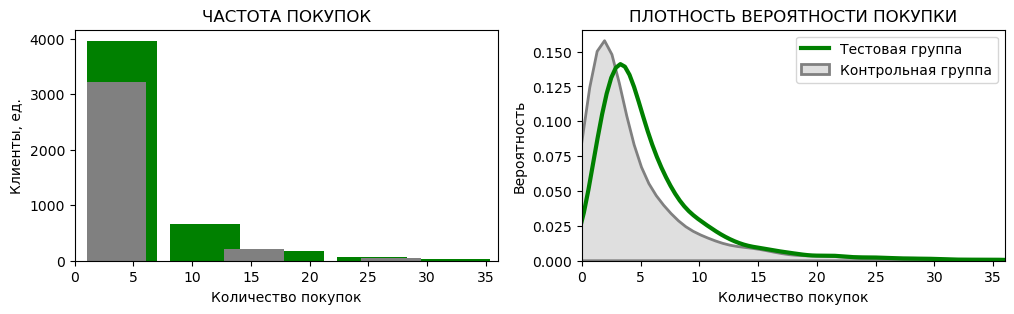

In [11]:
# Визуализируем распределения
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].set_title('ЧАСТОТА ПОКУПОК')
axs[0].set_ylabel('Клиенты, ед.')
axs[0].set_xlabel('Количество покупок')
axs[0].set_xlim(0, 36)
axs[1].set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПКИ')
axs[1].set_ylabel('Вероятность')
axs[1].set_xlim(0, 36)
axs[0].hist(df_test_client['product'], color='green',  width=+6)
axs[0].hist(df_control_client['product'], color='gray', width=+5.1)
axs[1] = sns.distplot(df_test_client['product'], hist=False, kde=True, color='green',
                      label='Тестовая группа', kde_kws = {'linewidth': 3})
axs[1] = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                      label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод:** Значительно возрасло количество клиентов, совершивших несколько покупок, что свидетельствует об эффективности рекланой кампании, которая привлекает клиентов за повторными покупками. Частота покупок, а следовательно и посещений клиентами магазинов стало более равномерным что позитивно для нагрузки на инфраструктуру обслуживания, так как требует более равного количества обслуживающего персонала в разные периоды работы магазинов. Это также подтверждается возросшей плотностью вероятности покупок (посещений) практисчески у всех клиентов, совершивших 3 и более покупок.

### 3.2.3. Проверка метрики "Увеличение частоты и суммы покупок наиболее состоятельными клиентами"

In [14]:
# Функция разметки данных по возрастным категориям 
# данные из статьи:
# https://blog.domclick.ru/ipoteka/post/kazhduyu-desyatuyu-ipoteku-v-sbere-berut-molodye-lyudi-analitika-domklik
def age_rank(age):
    if   age < 26: return 1 # меньшие доходы
    elif age < 31: return 2 # средние доходы
    elif age < 41: return 3 # наибольшие доходы
    elif age < 51: return 3 # наибольшие доходы
    elif age < 61: return 2 # средние доходы
    else: return 1 # меншие доходы
    
# Разметим данные 
df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))

/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/244107389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['age_rank'] = df_test['age'].apply(lambda x: age_rank(x))
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/244107389.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_control['age_rank'] = df_control['age'].apply(lambda x: age_rank(x))


In [15]:
# Сформируем выборки по возрастным категориям и стоимости покупок
df_test_age = df_test.groupby('age_rank').agg({'cost': 'sum'})
df_control_age = df_control.groupby('age_rank').agg({'cost': 'sum'})

In [16]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['cost'], df_control_age['cost'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 6.376481%
  - вторая выборка: 8.279554%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 75.567725%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 38.020606%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.06376481056213379,
  'p-value df2': 0.08279553800821304},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7556772546730324},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.3802060638211032}}

In [17]:
# Сформируем выборки по возрастным категориям и частоте покупок
df_test_age = df_test.groupby('age_rank').agg({'product': 'count'})
df_control_age = df_control.groupby('age_rank').agg({'product': 'count'})

In [18]:
# Применим разработанный класс (см. файл package.select_run_test)
# для определения статистически значисого отличия сформированных выборок
test = SampleComparisonTest(print_console_flag=True)
test.select_run_test(df_test_age['product'], df_control_age['product'])


Пользователь задал условие - выборки НЕЗАВИСИМЫЕ

 Проверка каждой выборки на прараметричность тестом Шапира-Уилка
 ЗНАЧЕНИЯ p-value ВЫБОРОК
  - первая выборка: 13.581373%
  - вторая выборка: 11.491381%
--------------------------------------
 ВЫВОД: Все выборки ПАРАМЕТРИЧЕСКИЕ (распеределены по нормальному закону распределения)

 Проверка равенства Дисперсий выборок тестом Левене
 ЗНАЧЕНИЕ p-value: 71.835853%
--------------------------------------
 ВЫВОД: Дисперсии выборок - РАВНЫЕ


  Для сравнения выборок выбран тест: Т-критерий Стьюдента
 ЗНАЧЕНИЕ p-value при тестировании выборок: 39.650172%
-------------------------------------------------------
 ВЫВОД: выборки статистически значимо НЕ ИМЕЮТ РАЗНИЦЫ (гипотеза H0)


{'Условие зависимости выборок': 'no_dependency',
 'Предпроверка 1': {'name_test': 'Тест Шапиро',
  'p-value df1': 0.13581372797489166,
  'p-value df2': 0.11491381376981735},
 'Предпроверка 2': {'name_test': 'Тест Левене', 'p-value': 0.7183585280977867},
 'Результат': {'name_test': 'Т-критерий Стьюдента',
  'p-value': 0.39650172030040165}}

**Вывод:** проведение рекламной кампании не позволило увеличить стоимость и частоту покупок более состоятельной группой клиентов.

**Общие выводы**:
1) Рекламная кампания мотивировала большее количество клиентов на повторные покупки и значительно увеличила выручку. Это с одно стороны позволит снизить издержк и на инфраструктуру обслуживания клинетов, так как она будет загружена более равномерно, а с другой стороны увеличит доходы за счёт повтороного возврата клиентов, ожидающих дополнительных акций. Для поддержания эффекта целесообразно посторять такие рекламные кампании с сезонной периодичночтью.  
2) Однако, в отношении наиболее состоятельных групп клиентов - в будущих кампаниях рекомендуется акцентировать внимание на конкретных возростных групах, таким образом, чтобы наиболее сильно мотивировать к повторным покупкам группы клиентов со средним и высоким доходом (от 31 до 61 года), которые смогут в будущем совершать более дорогие и более частые покупки.

## 3.3. Оценка второй рекламной кампании

Поскольку вторая рекламная кампания проводилась на отдельной территории (город №1134) её эффективность можно проверить по изменившейся плотности вероятночти покупок покупателями в дни акции в данном городе в сравнении с другими городами

In [19]:
# Получим датасет выбранный для AB тестирования второй маркетенговой компании
df_AB_2 = df_all[~df_all.test.isna()]
df_test = df_AB_2[(df_AB_2.city == 1134) & (df_AB_2.dt.isin([15, 45]))]
df_control = df_AB_2[(df_AB_2.city != 1134) & (df_AB_2.dt.isin([15, 45]))]
# Сформируем выборки по частоте покупок покупателями
df_test_client = df_test.groupby('id').agg({'product': 'count'})
df_control_client = df_control.groupby('id').agg({'product': 'count'})
print(f"Количество покупателей в городе 1134 (тестовая группа): {len(df_test_client)}")
print(f"Количество покупателей в других городах (контрольная группа): {len(df_control_client)}")

Количество покупателей в городе 1134 (тестовая группа): 796
Количество покупателей в других городах (контрольная группа): 1973


Так как вторая рекламна кампания проводилась через канал в конкретном городе, количесвто пользователей которого неконтролируется, то контрольную группу для такой кампании можно выбрать в качестве контрольной группы только покупателей на других территориях. Соответсвенно оценку проведённой рекламной кампании будем проводить по относительному показателю (плотность вероятности покупок), а значит балансировка размеров тестовой и контрольной выборок нецелесообразны.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


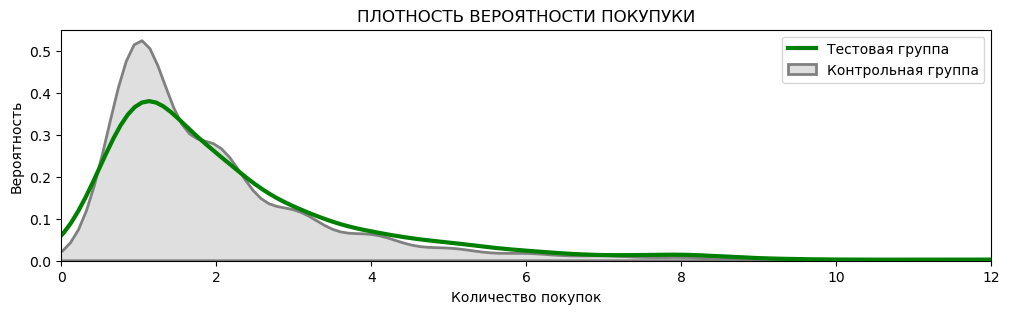

In [20]:
# Визуализируем распределения
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('ПЛОТНОСТЬ ВЕРОЯТНОСТИ ПОКУПУКИ')
ax.set_ylabel('Вероятность')
ax.set_xlim(0, 12)
ax = sns.distplot(df_test_client['product'],hist=False, kde=True, color='green',
                  label='Тестовая группа', kde_kws = {'linewidth': 3})
ax = sns.distplot(df_control_client['product'], hist=False, kde=True, color='gray',
                  label='Контрольная группа', kde_kws = {'shade': True, 'linewidth': 2})
plt.xlabel('Количество покупок')
plt.legend();

**Вывод**: Вторая рекламная кампания снизила вероятноть 1 покупки, что является положительным фактором, в случае роста вероятности нескольких покупок, однако этого не произошло. Таким образом вторую рекламную кампанию можно прихзнать неудачной. В будущем её необходимо переработать, например сориентировав на группы с большей доходностью, либо отказаться от её проведения.

# 4. Кластеризация покупателей

## 4.1. Формирование двумерного пространства признаков

In [41]:
# Выделим числовые признаки
df_num = df_all[df_all.columns[(df_all.dtypes == 'int64') | (df_all.dtypes == 'float64')]].\
                            drop(['lbt_coef', 'ac_coef', 'sm_coef'], axis=1)
# Заменим в признак test значение None на значение 2
df_num.test = df_num.test.fillna(3)
# Масштабируем числовые признаки
features = [col for col in df_num.columns]
scaler = StandardScaler()
df_num_sc = pd.DataFrame(data=scaler.fit_transform(df_num[features]), columns=df_num[features].columns)

In [42]:
# Выделим категориальные признаки
df_cat = df_all[df_all.columns[df_all.dtypes == 'object']]
# Закадируем категориальные признаки
oe = OrdinalEncoder()
df_cat_le = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
# Масштабируем числовые признаки
scaler = StandardScaler()
df_cat_sc = pd.DataFrame(data=scaler.fit_transform(df_cat_le), columns=df_cat.columns)

In [43]:
# Объединим числовые и категориальные признаки
df_num_cat_sc = df_num_sc.join(df_cat_sc)
df_num_cat_sc.head(3)

,id,cost,product_sex,base_sale,dt,gender,age,city,country,personal_coef,test,product,colour,education
0,-1.733221,0.788117,-1.439474,1.342400,-1.048121,-1.106019,-0.202393,0.373988,0.003368,0.766638,-1.786328,-1.328615,-1.483383,0.499865
1,-1.733221,-0.375910,1.073246,-0.744935,0.686307,-1.106019,-0.202393,0.373988,0.003368,0.766638,-1.786328,0.969724,-0.999844,0.499865
2,-1.733221,-0.058448,1.073246,-0.744935,0.686307,-1.106019,-0.202393,0.373988,0.003368,0.766638,-1.786328,0.088564,-1.840781,0.499865


In [45]:
# Преобразуем пространство признаков в двухмерное
tsne = TSNE(n_components=2, n_jobs=-1)
df_num_cat_sc_tsne = tsne.fit_transform(df_num_cat_sc)
df_num_cat_sc_tsne

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[  2.8411436 , -22.567564  ],
       [  1.2614385 , -15.069403  ],
       [  1.6801554 , -14.946504  ],
       ...,
       [-17.026966  ,   0.08176214],
       [  0.07349106,  13.855477  ],
       [  3.690574  ,   9.176502  ]], dtype=float32)

In [47]:
# Добавим координаты двумерного пространства в датасет
df_all[['X', 'Y']] = df_num_cat_sc_tsne
df_all.head(3)

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,test,X,Y
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,2.841144,-22.567564
1,0,Стол Outventure,зеленый,1499,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,1.261438,-15.069403
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,2.0,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1.0,1.680155,-14.946504


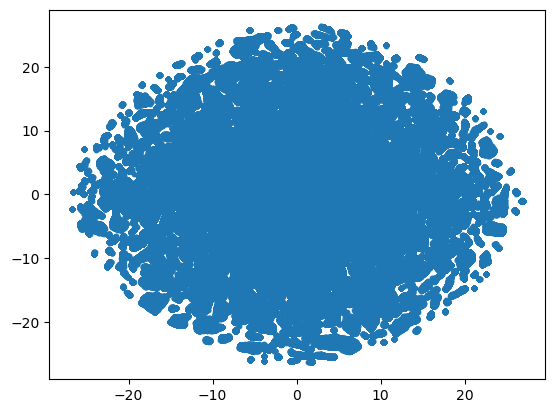

In [48]:
# Визуализируем полученные координаты точек двухмерного пространства
plt.scatter(df_all['X'], df_all['Y'], s=10);

## 4.2. Кластаризация методом К-средних

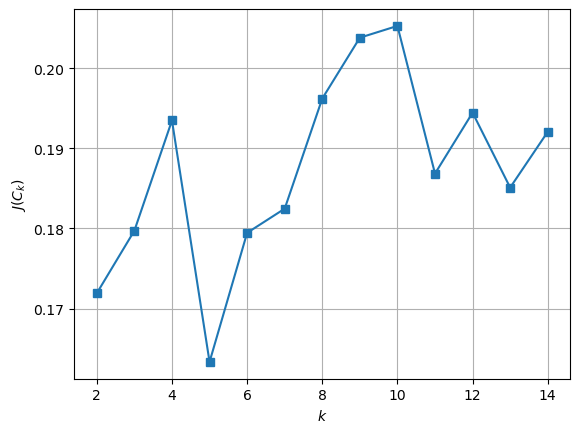

In [52]:

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
# Определение оптимального количества кластеров
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10).fit(df_num_sc)
    preds = kmeans.predict(df_num_sc)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_num_sc, preds))
    print(f'Расчитан шаг №{k-1} для {k} кластеров.')

# Определим (графически) "колена", характеризующие оптимальное количесвто кластеров
plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

Проверим визуально наиболее ярко выраженные участки графика (колени)

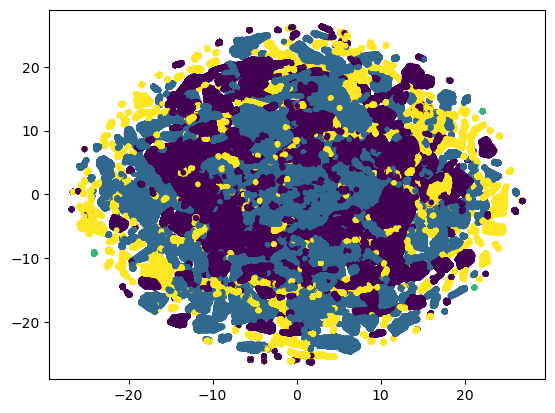

In [55]:
# Разбиение на 4 кластера
kmeans_4 = KMeans(n_clusters=4, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_4.labels_);

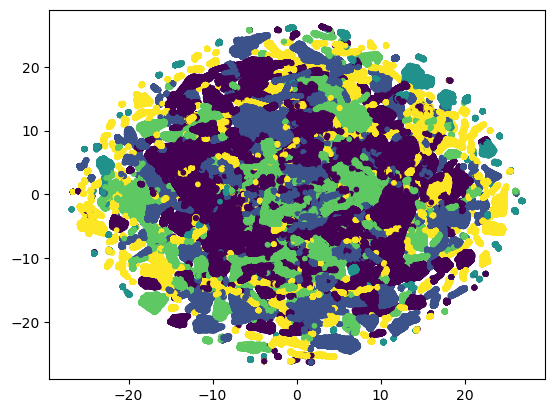

In [57]:
# Разбиение на 5 кластера
kmeans_5 = KMeans(n_clusters=5, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_5.labels_);

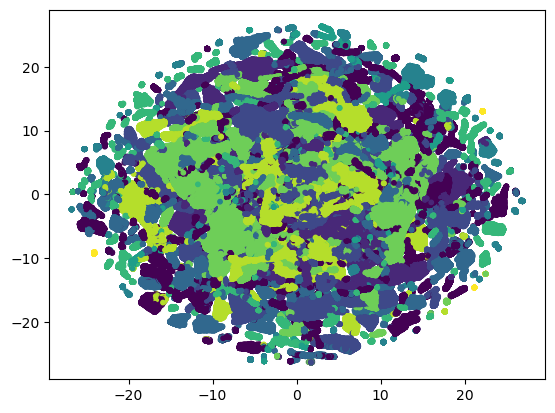

In [58]:
# Разбиение на 10 кластера
kmeans_10 = KMeans(n_clusters=10, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_10.labels_);

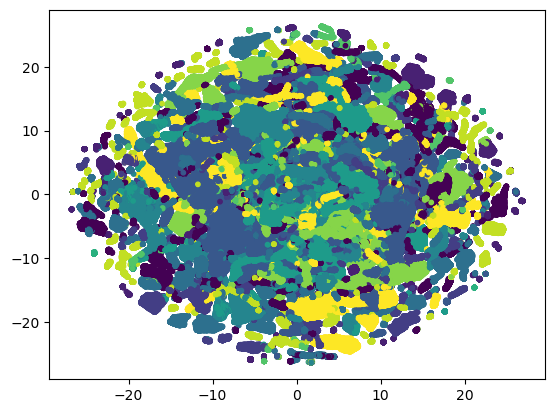

In [60]:
# Разбиение на 12 кластера
kmeans_12 = KMeans(n_clusters=12, n_init=10).fit(df_num_cat_sc)
plt.scatter(df_all['X'], df_all['Y'], s=10, c=kmeans_12.labels_);

**Выводы:** Визуально видно что при увеличении количества кластеров разделения покупателей на явные группы не улучшается. Кроме того при увеличении числа кластеров рвозрастает вероятность ошибочного отнесения точек пространства к кластерам. Таким образом целесообразно выбрать минималное количество кластеров представленное в оптимально выбранном списке "количества кластеров", то есть 8 кластеров.

## 4.3. Определим по каким основным признакам сгруппировались кластеры

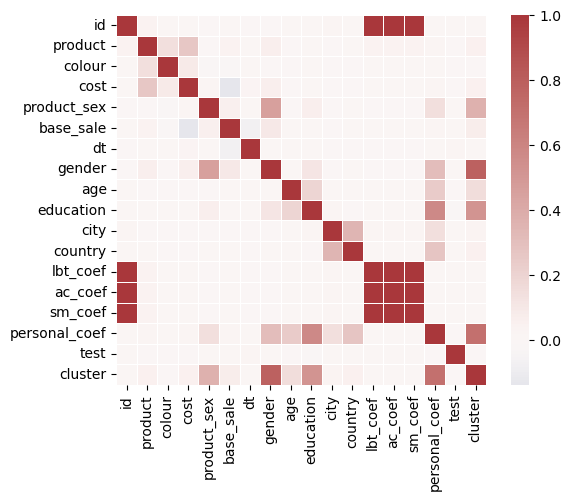

In [89]:
# Сформируем признаки кластеров для датасета
df_cluster = pd.DataFrame(data=kmeans_4.labels_, columns=['cluster'])
# Добавим признаки кластеров в датасет клииентов
df_cluster =df_all.join(df_cluster).drop(['X', 'Y'], axis=1)
# Выделим корреляцуии кластеров и иных признаков у покупок
corr_mat = df_cluster.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr_mat, cmap='vlag', center=0, square=True, linewidths=.5)
plt.show()

In [90]:
# Выведем коэффициенты влияния отдельных признаков на отнесение покупок к кластерам 
corr_mat.cluster.sort_values(ascending=False)[1:]

gender           0.785320
personal_coef    0.705335
education        0.518387
product_sex      0.369485
age              0.152833
base_sale        0.074908
country          0.057868
cost             0.055602
product          0.055151
city             0.037378
dt               0.004472
ac_coef          0.001747
lbt_coef         0.001726
sm_coef          0.001726
id               0.001726
test            -0.002887
colour          -0.006391
Name: cluster, dtype: float64

**Вывод**: Разбиение на кластеры выявило признаки, по группе которых можно распределить клиентов таким образом что бы они проявляли одинаковые поведенческие патерны. Это значит что для повышения эффективности рекламных кампаний целесообразно делать их направленными на клиентов, с разными признаками: `gender`, `personal_coef`, `education` - так как отличие именно этих прзнаков клиентов имеет сильную и среднюю корреляцию с разделением клиентов на кластеры.

## 4.4. Определение наиболее часто приобретаемых товаров в кластерах

In [168]:
# Выберем наиболее важные признаки при отнесении покупок к кластерам и получим датасет для клаччификации
importent_fit = list()
for name, value in zip(corr_mat, corr_mat.cluster):
    if value > 0.009: importent_fit.append(name)
importent_fit
df = df_cluster[importent_fit]
fit_columns = importent_fit[:-1]

In [230]:
# Функция многофакторной классификации датасета по признаку 'cluster'
def cluster_classifier(df, cluster):
    df = df_cluster[importent_fit] # Зададим исследуемый датасет
    # Выделим и закодируем категориальные признаки
    df_cat = df[df.columns[df.dtypes == 'object']]
    oe = OrdinalEncoder()
    df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
    # Масштабируем все признаки
    scaler = StandardScaler()
    df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
    df['cluster'] = df['cluster'].apply(lambda x: 1 if x == cluster else 0)
    rf = RandomForestClassifier()
    rf.fit(df[fit_columns], df['cluster'])
    fit_imp = dict()
    base_sale = 0
    for name, value in zip (fit_columns, rf.feature_importances_):
        if value > 0.009:
            fit_imp[name] = round(value, 6)
        if name == 'base_sale':
            base_sale = round(value, 6)
    str_1 = f'Признаки, по которым объединён кластер {cluster}, с важностью признака более 1%:\n'\
            f'{sorted(fit_imp.items(), key=lambda item: item[1], reverse=True)}\n' \
            f'Признак `base_sale` имеет существенность с долей: {base_sale}'
    return str_1

In [231]:
# Функция выявления 10 наиболее часто приобретаемых товаров в кластере
def choese_top(df):
    return df.groupby('product').agg({'id': 'count'}).id.sort_values(ascending=False)[:10]

# Выведим наиболее часто преобретаемые товары в каждом кластере
for elem in sorted(df_cluster.cluster.unique()):
    print(cluster_classifier(df, elem))
    print(f'Клиенты, отнесённые к кластеру {elem} '
          f' наиболее часто преобретают следующие товары:\n'
          f'{choese_top(df_cluster[df_cluster.cluster == elem])}\n')

/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/19836592

Признаки, по которым объединён кластер 0, с важностью признака более 1%:
[('personal_coef', 0.421732), ('gender', 0.334252), ('age', 0.106603), ('education', 0.102817), ('product_sex', 0.022999)]
Признак `base_sale` имеет существенность с долей: 0.000866
Клиенты, отнесённые к кластеру 0  наиболее часто преобретают следующие товары:
product
Брюки мужские Demix              3048
Шорты мужские Demix              2642
Футболка мужская Demix           2178
Брюки мужские Outventure         2009
Брюки мужские FILA               1414
Толстовка мужская Demix          1122
Сабо Crocs Crocband              1018
Кресло кемпинговое Outventure     872
Лиф женский Joss                  800
Солнцезащитные очки Kappa         787
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/19836592

Признаки, по которым объединён кластер 1, с важностью признака более 1%:
[('personal_coef', 0.52452), ('gender', 0.399864), ('product_sex', 0.03229), ('age', 0.028128)]
Признак `base_sale` имеет существенность с долей: 0.001176
Клиенты, отнесённые к кластеру 1  наиболее часто преобретают следующие товары:
product
Футболка женская Demix               2597
Лиф женский Joss                     2339
Купальник женский Joss               2141
Брюки женские Outventure             2031
Плавки женские Joss                  1893
Легинсы женские Demix                1760
Брюки женские FILA                   1675
Ветровка женская Outventure          1500
Брюки женские Demix                  1473
Балетки женские Demix Ballerina 2    1293
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/19836592

Признаки, по которым объединён кластер 2, с важностью признака более 1%:
[('country', 0.811677), ('city', 0.109398), ('personal_coef', 0.043123), ('age', 0.024769)]
Признак `base_sale` имеет существенность с долей: 0.000463
Клиенты, отнесённые к кластеру 2  наиболее часто преобретают следующие товары:
product
Куртка утепленная мужская Northland    8
Плавки женские Joss                    7
Брюки женские Outventure               6
Футболка мужская Demix                 6
Кроссовки женские Demix Flow           5
Брюки мужские FILA                     5
Лиф женский Joss                       5
Шорты мужские Demix                    4
Палки треккинговые Outventure          4
Шорты плавательные мужские FILA        4
Name: id, dtype: int64



/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_cat.columns] = pd.DataFrame(data=oe.fit_transform(df_cat), columns=df_cat.columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/1983659238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fit_columns] = pd.DataFrame(data=scaler.fit_transform(df[fit_columns]), columns=fit_columns)
/var/folders/5h/1vkpjwr90l19cmzfgsfrcpvm0000gp/T/ipykernel_1273/19836592

Признаки, по которым объединён кластер 3, с важностью признака более 1%:
[('education', 0.358852), ('age', 0.29196), ('personal_coef', 0.26148), ('gender', 0.069507)]
Признак `base_sale` имеет существенность с долей: 0.000649
Клиенты, отнесённые к кластеру 3  наиболее часто преобретают следующие товары:
product
Шорты мужские Demix         871
Брюки мужские Demix         725
Брюки мужские FILA          629
Футболка мужская Demix      617
Шорты мужские Nike          504
Сабо Crocs Crocband         453
Брюки мужские Outventure    421
Брюки мужские Kappa         384
Футболка мужская Termit     354
Футболка мужская FILA       313
Name: id, dtype: int64



**Выводы:**  
1) При определении каждого кластера клиентов одним из важных является признак `age`. Это означает, что при разработке рекламных компаний целесообразно, в первую очередь, необходимо акцентировать её направленность на конкретные возрастные группы. А учитывая рекомендации из п.3 настоящено иисследовнаия - дополниьельно стоит учитывать статистику доходов возрастных групп: 
 - Так клиентам от 31 до 61 года целесообразно предлагать наиболее дорогие и бОльшие по комплектации товары.
 - При достаточности ресурсов на рекламные кампании целесообразно разработать и провести отдельные кампании на каждую возрастную группу, определённую признаком доходности: менее 31 года, от 31 до 61 года, старше 61 года.
 - При недостаточности ресурсов на рекламные кампании целесообразно разработать и провести кампанию для группы клиентов с наибольшим доходом - от 41 до 51 года. Для повышения имеджа компании как социально направленной можно исключит верхний диапазон акции и провести её для всех клиентолв старше 41 года.  

2) Для клиентов из кластера 0, 1, 3 одним из важных признаков является `gender`. Соответственно целесообразно разработать отдельные рекламные компании для женщин и мужчин и провести их в разные периоджы времени, чтобы продавцы консультанты спавлялись с потоком покупателей и концентрировались на продажах более уского спектра товаров, что в свою очередь повысит качество предпродажных консульаций и соответственно повысит количество продаж.     
3) При контакте с клиентом целесобразно сразу определять кдастер, к кторому он относится и предлагать ему дополнительно приобрести перечень товаров из топ-10 товаров, наиболее часто преобретаемых клиентами соответсвующего кластера (см.выше для каждого кластера).  
4) Доля существенности для клиентов наличия скидки составляет около 7,5% (см. оценку важности доли выше)

## 4.5. Определение доли существенности скидки для клиентов каждого кластера

In [318]:
# Функция определения статистически значимой разницы в покупках при наличии скидки
def get_difference(df, option):
    df_test = df[(df.cluster == cluster) & (df.test == 1)].groupby('dt').agg({'cost': option})
    df_control = df[(df.cluster == cluster) & (df.test == 0)].groupby('dt').agg({'cost': option})
    test = SampleComparisonTest() # print_console_flag=True - флаг для вывода информации в консоль
    test.select_run_test(df_test['cost'], df_control['cost'])
    if test.select_run_test(df_test['cost'], df_control['cost'])['Результат']['p-value'] < 0.05:
        print(f'В кластере {cluster} скидка влияет на покупки')
        fig, ax = plt.subplots(figsize=(12, 3))
        ax.set_title('РАСПРЕДЕЛЕНИЕ СТОИМОСТИ ПОКУПОК ПО ДНЯМ ПЕРВОЙ РЕКЛАМНОЙ КАМПАНИИ')
        ax.set_ylabel('Количество покупок, шт.')
        ax.set_xlabel('Дни первой покупки')
        ax.bar(df_test.index, df_test['cost'], width=0.3, color='green', label='Тестовая группа')
        ax.bar(df_control.index+0.4, df_control['cost'], width=0.6, color='gray', label='Контрольная группа')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        plt.legend();

В кластере 3 скидка влияет на покупки


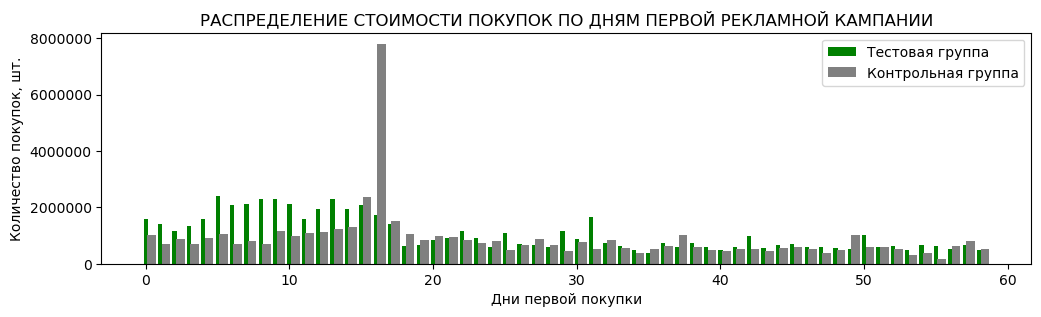

In [319]:
# Определим в каких кластерах скидка влияет на сумму покупок
for cluster in df.cluster.unique():
    get_difference(df_cluster[df_cluster.cluster == cluster], 'sum')

В кластере 0 скидка влияет на покупки
В кластере 3 скидка влияет на покупки


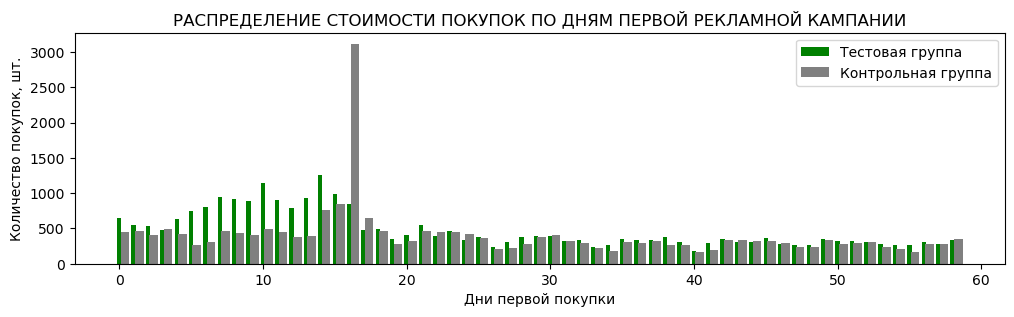

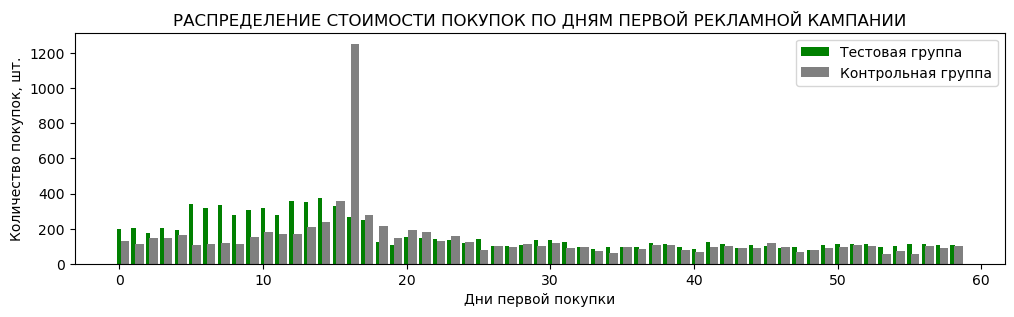

In [320]:
# Определим в каких кластерах скидка влияет на сумму частоту покупок
for cluster in df.cluster.unique():
    get_difference(df_cluster[df_cluster.cluster == cluster], 'count')

**Вывод**: при предоставлении скидки покупки статистически значимо увеличиваются:  
1) По сумме покупок - для клиентов кластера 3.  
2) По количеству покупок - для клиентов кластеров 0 и 3.  
  
Таким образом среди клиентов вышеуказанных кластеров целесообразно проводить рекламные кампании, включающие в себя такую опцию как скидка.